#### Auxiliary notebook, for filling in the NaN weather values

# QRT ENS Data Challenge 2023 (Filling NaN Weather)
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from utils import *

In [2]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')
pd.set_option('display.max_columns', None)
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

weather_vars = ['DE_RAIN', 'DE_WIND', 'DE_TEMP', 'FR_RAIN', 'FR_WIND', 'FR_TEMP']

In [3]:
ls = de.index
for i in range(ls.size - 1):
    if ls[i + 1] - ls[i] > 2:
        print(f'{i}, {ls[i]}, {ls[i + 1]}')

4, 5, 8
19, 28, 32
50, 72, 76
58, 86, 89
85, 119, 122
86, 122, 127
96, 138, 141
97, 141, 144
103, 150, 154
119, 171, 175
122, 178, 181
130, 189, 192
150, 216, 219
153, 221, 224
172, 248, 251
187, 269, 272
188, 272, 275
230, 324, 327
236, 333, 336
264, 372, 376
269, 382, 386
288, 409, 412
289, 412, 415
290, 415, 419
295, 424, 429
303, 439, 442
307, 446, 449
333, 482, 485
338, 490, 493
353, 512, 515
362, 523, 526
385, 553, 556
387, 557, 560
399, 576, 579
408, 588, 594
459, 656, 659
467, 667, 670
469, 671, 674
479, 686, 689
486, 696, 701
487, 701, 705
488, 705, 708
512, 741, 744
517, 749, 752
531, 767, 771
534, 774, 777
544, 789, 794
550, 801, 805
556, 813, 818
607, 878, 884
616, 896, 899
619, 902, 905


<Axes: xlabel='ID', ylabel='FR_TEMP'>

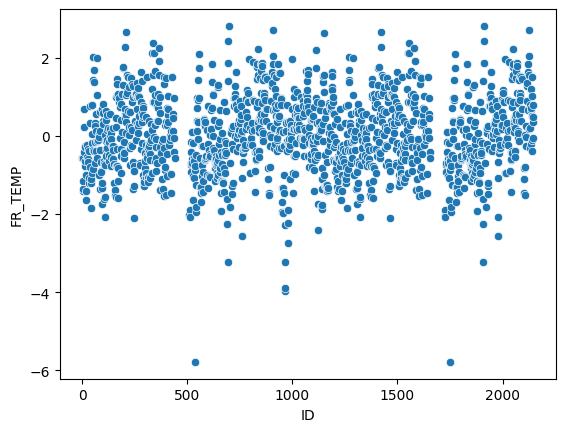

In [4]:
sns.scatterplot(x=df.index, y=df['FR_TEMP'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

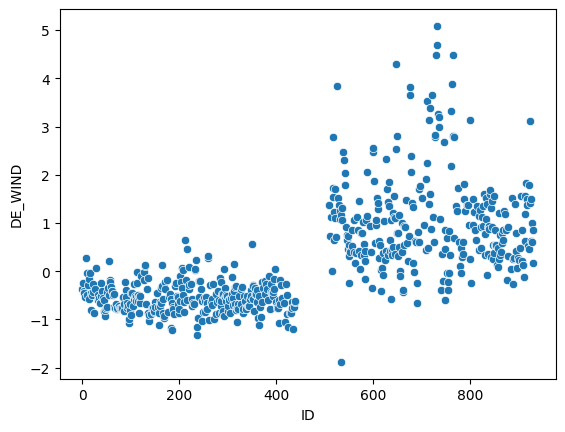

In [5]:
sns.scatterplot(x=de.index, y=de['DE_WIND'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

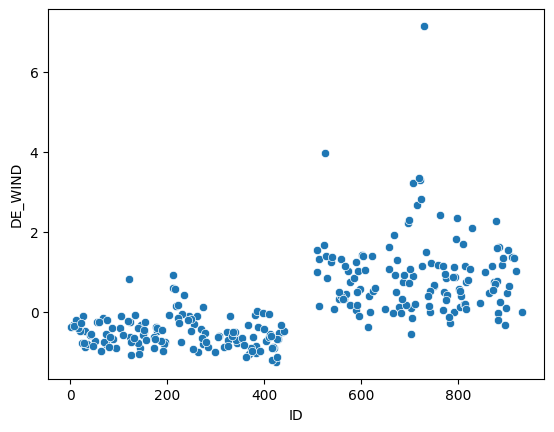

In [6]:
sns.scatterplot(x=true_test[true_test['COUNTRY'] == 'DE'].index, y=true_test[true_test['COUNTRY'] == 'DE']['DE_WIND'])

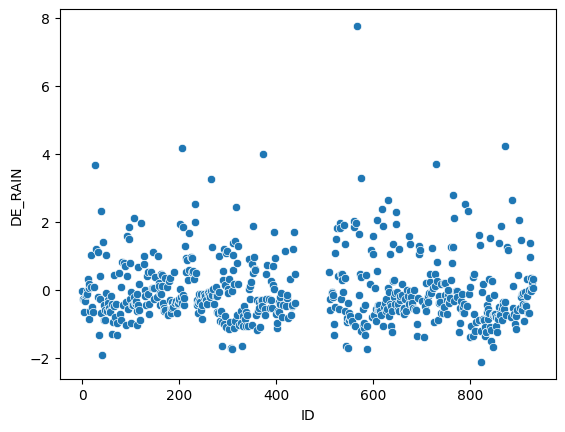

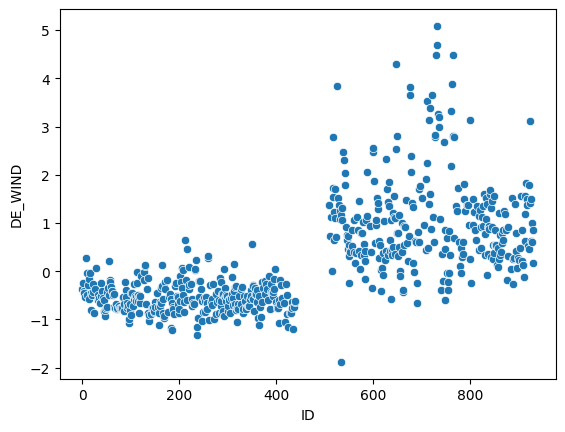

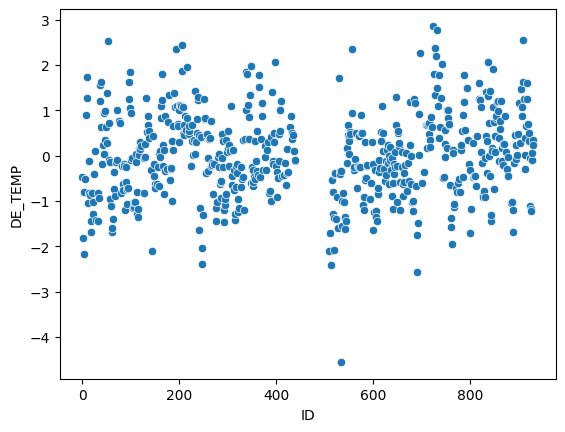

In [7]:
temp_de = de.copy()
temp_de['TARGET'] = y_de['TARGET']
for w in ['RAIN', 'WIND', 'TEMP']:
    plt.figure()
    sns.scatterplot(x=temp_de.index, y=temp_de[f'DE_{w}'])

In [8]:
cols = pd.DataFrame(de.drop(['COUNTRY'], axis=1).columns)
for w in ['RAIN', 'WIND', 'TEMP']:
    cols[f'MI_FR_{w}'] = mir(X=de.drop(['COUNTRY'], axis=1).dropna(), y=de[f'FR_{w}'].dropna())
cols

,0,MI_FR_RAIN,MI_FR_WIND,MI_FR_TEMP
0,DAY_ID,0.000934,0.036192,0.032111
1,DE_CONSUMPTION,0.016604,0.015827,0.036365
2,FR_CONSUMPTION,0.048017,0.091916,0.083235
3,DE_FR_EXCHANGE,0.034826,0.073933,0.000000
4,FR_DE_EXCHANGE,0.034873,0.073974,0.000000
5,DE_NET_EXPORT,0.013820,0.045334,0.008402
6,FR_NET_EXPORT,0.028125,0.120151,0.026735
7,DE_NET_IMPORT,0.013820,0.045286,0.008402
8,FR_NET_IMPORT,0.028125,0.120151,0.026735
9,DE_GAS,0.047457,0.122781,0.038185


[51.64124124124124, 133.20650650650649, 170.7365365365365, 375.90070070070067, 413.4307307307307, 494.99599599599594]
[51.64124124124124, 88.67087087087086, 133.20650650650649, 183.2465465465465, 363.3906906906907, 413.4307307307307, 457.96636636636634, 494.99599599599594]


<Figure size 640x480 with 0 Axes>

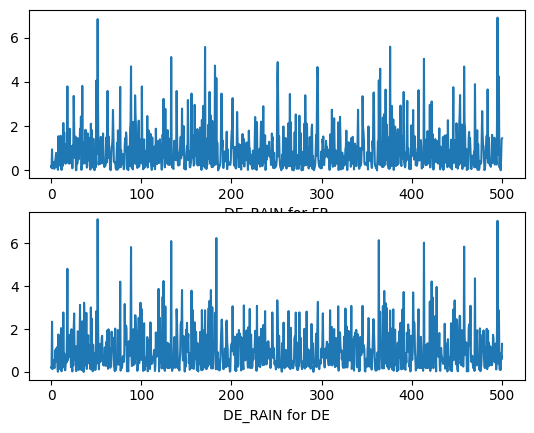

[25.120020020020018, 56.64524524524524, 177.24174174174172, 201.26096096096094, 345.37627627627626, 369.3954954954955, 420.9367367367367, 489.99199199199194]
[18.614814814814814, 25.120020020020018, 50.640440440440436, 56.64524524524524, 113.19049049049048, 120.69649649649648, 182.24574574574572, 201.26096096096094, 257.8062062062062, 269.8158158158158, 276.8214214214214, 288.83103103103105, 345.37627627627626, 364.3914914914915, 425.9407407407407, 433.4467467467467, 489.99199199199194, 495.9967967967968]


<Figure size 640x480 with 0 Axes>

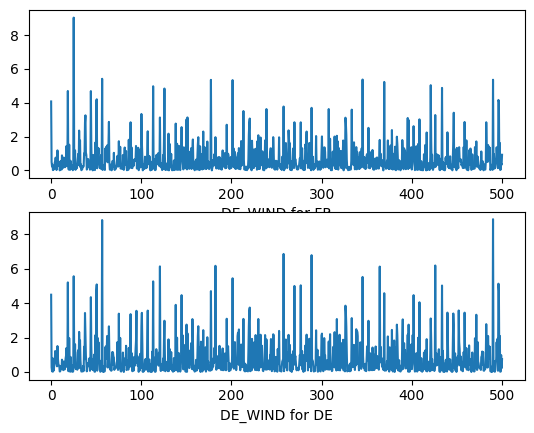

[0.1, 25.120020020020018, 44.135235235235236, 56.14484484484484, 68.65485485485485, 75.16006006006005, 94.17527527527525, 119.69569569569568, 125.70050050050048, 150.7205205205205, 163.7309309309309, 169.23533533533532, 169.73573573573572, 182.24574574574572, 194.75575575575573, 207.26576576576574, 213.77097097097095, 232.78618618618614, 257.8062062062062, 263.81101101101103, 282.8262262262262, 288.83103103103105, 313.85105105105106, 339.37147147147147, 351.88148148148144, 364.3914914914915, 376.90150150150146, 377.4019019019019, 382.9063063063063, 395.9167167167167, 420.9367367367367, 426.94154154154154, 452.46196196196195, 471.47717717717717, 477.98238238238235, 490.4923923923924]
[12.109609609609608, 25.120020020020018, 31.625225225225222, 44.135235235235236, 94.17527527527525, 106.18488488488487, 125.70050050050048, 157.2257257257257, 169.23533533533532, 194.75575575575573, 226.28098098098096, 232.28578578578575, 251.30100100100097, 257.3058058058058, 257.8062062062062, 263.8110110

<Figure size 640x480 with 0 Axes>

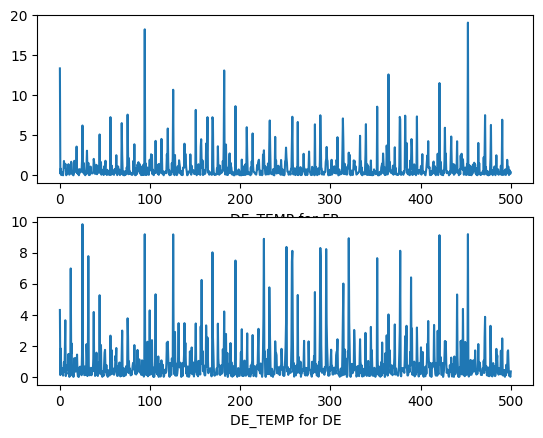

[50.140040040040034, 77.66206206206205, 81.66526526526525, 163.2305305305305, 175.2401401401401, 383.4067067067067, 464.9719719719719, 468.97517517517514, 496.4971971971972]
[50.140040040040034, 77.66206206206205, 106.68528528528527, 134.20730730730727, 224.77977977977974, 321.85745745745743, 412.4299299299299, 439.9519519519519, 464.9719719719719, 468.97517517517514, 496.4971971971972]


<Figure size 640x480 with 0 Axes>

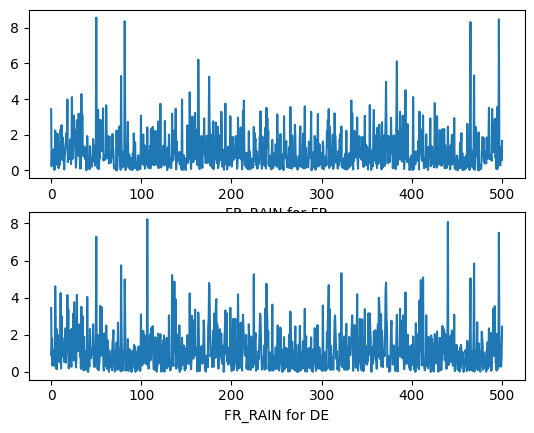

[25.120020020020018, 138.2105105105105, 201.26096096096094, 263.81101101101103, 282.8262262262262, 345.37627627627626, 408.4267267267267]
[138.2105105105105, 144.7157157157157, 201.26096096096094, 207.26576576576574, 257.8062062062062, 288.83103103103105, 339.37147147147147, 345.37627627627626, 401.9215215215215, 408.4267267267267]


<Figure size 640x480 with 0 Axes>

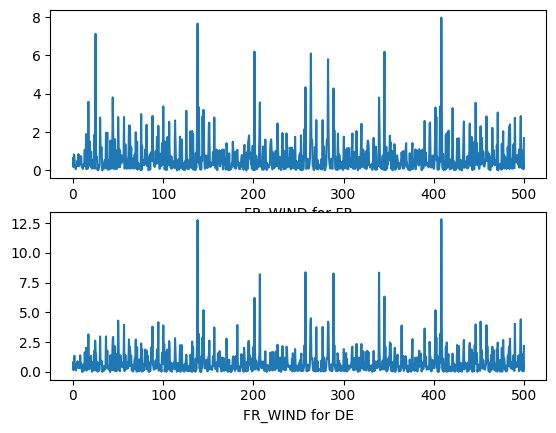

[0.1, 6.605205205205204, 25.120020020020018, 56.14484484484484, 75.66046046046044, 119.69569569569568, 125.20010010010009, 125.70050050050048, 132.7061061061061, 138.2105105105105, 169.23533533533532, 169.73573573573572, 182.24574574574572, 188.2505505505505, 213.77097097097095, 226.28098098098096, 232.78618618618614, 257.8062062062062, 288.83103103103105, 313.85105105105106, 320.35625625625624, 332.8662662662663, 358.3866866866867, 376.90150150150146, 377.4019019019019, 408.4267267267267, 413.9311311311311, 420.9367367367367, 426.94154154154154, 470.9767767767768, 471.47717717717717, 490.4923923923924]
[6.104804804804804, 19.115215215215215, 25.120020020020018, 56.14484484484484, 75.66046046046044, 99.67967967967967, 131.70530530530527, 169.23533533533532, 169.73573573573572, 188.2505505505505, 201.26096096096094, 226.28098098098096, 257.8062062062062, 288.83103103103105, 320.35625625625624, 345.37627627627626, 358.3866866866867, 376.90150150150146, 377.4019019019019, 414.931931931931

<Figure size 640x480 with 0 Axes>

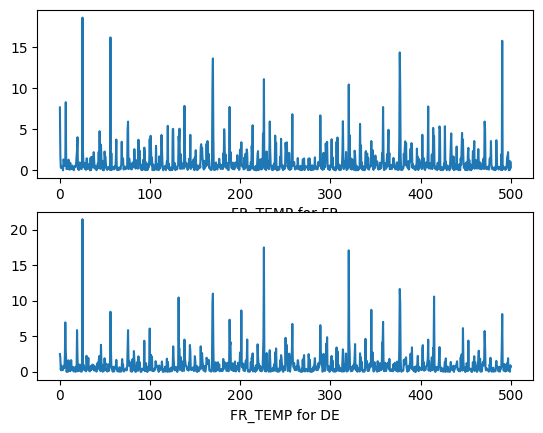

In [9]:
fs = np.linspace(0.1, 500, 1000)
for col in weather_vars:
    plt.figure()
    fig, axs = plt.subplots(2)
    
    pgram = signal.lombscargle(x=fr[col].dropna().index, y=fr[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 5).ravel()])
    p_fr = sns.lineplot(x=fs, y=pgram, ax=axs[0])
    p_fr.set(xlabel=f'{col} for FR')
    
    pgram = signal.lombscargle(x=de[col].dropna().index, y=de[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 5).ravel()])
    p_de = sns.lineplot(x=fs, y=pgram, ax=axs[1])
    p_de.set(xlabel=f'{col} for DE')
    
    plt.show()

In [10]:
de.count()

DAY_ID              643
COUNTRY             643
DE_CONSUMPTION      643
FR_CONSUMPTION      643
DE_FR_EXCHANGE      643
FR_DE_EXCHANGE      643
DE_NET_EXPORT       643
FR_NET_EXPORT       643
DE_NET_IMPORT       643
FR_NET_IMPORT       643
DE_GAS              643
FR_GAS              643
DE_COAL             643
FR_COAL             643
DE_HYDRO            643
FR_HYDRO            643
DE_NUCLEAR          643
FR_NUCLEAR          643
DE_SOLAR            643
FR_SOLAR            643
DE_WINDPOW          643
FR_WINDPOW          643
DE_LIGNITE          643
DE_RESIDUAL_LOAD    643
FR_RESIDUAL_LOAD    643
DE_RAIN             596
FR_RAIN             596
DE_WIND             596
FR_WIND             596
DE_TEMP             596
FR_TEMP             596
GAS_RET             643
COAL_RET            643
CARBON_RET          643
dtype: int64

In [11]:
df_weather = country_flow(fourier_features(de)).drop(['DAY_ID', 'COUNTRY'], axis=1)

weather_train = df_weather[df_weather['DE_RAIN'].notna()]
weather_test = df_weather[df_weather['DE_RAIN'].isna()]

y = weather_train[['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP']]
weather_train = weather_train.drop(['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP'], axis=1)
weather_test = weather_test.drop(['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP'], axis=1)

### Feature Engineering

In [12]:
y

,DE_WIND,DE_RAIN,DE_TEMP,FR_WIND,FR_RAIN,FR_TEMP
ID,,,,,,
0,-0.370706,-0.047033,-0.466573,-0.844921,-0.248052,-0.558732
2,-0.248671,-0.274901,-1.817422,-0.135046,-0.347173,-1.163299
3,-0.409482,-0.672022,-2.170678,-0.236677,-0.421214,-1.399423
4,-0.444411,-0.300883,-0.795390,-0.622197,-0.148592,-1.352885
5,-0.530196,-0.347601,-0.511760,-0.896302,0.035837,-0.562027
...,...,...,...,...,...,...
926,1.506315,-0.042241,-1.225979,2.584335,0.517631,-0.113555
927,1.007158,0.086420,-0.107380,1.445712,0.643169,-0.046727
928,0.601170,0.213069,0.047149,1.439691,-0.442086,0.364089


### Models

In [13]:
x = lag_shift(weather_train, np.arange(3))
target = y
curr = 'FR_TEMP'
# de: ridge alpha 40, xgb gamma 25

In [14]:
weather_train

,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,GAS_RET,COAL_RET,CARBON_RET,SIN_365_1,COS365_1,SIN_365_2,COS365_2,SIN_365_3,COS365_3,SIN_106.81647765176784_1,COS106.81647765176784_1,SIN_106.81647765176784_2,COS106.81647765176784_2,SIN_106.81647765176784_3,COS106.81647765176784_3,TIME,EXCHANGE,SELF_EXPORT,OTHER_EXPORT,SELF_CONSUMPTION,OTHER_CONSUMPTION
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.836731,0.048137,0.200623,-0.777195,0.076310,-0.664384,0.780177,0.661807,0.390828,0.598856,-0.012385,-0.970238,0.625910,0.293219,0.448995,1.602466,1.527066,1.790950,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0.778353,0.931374,-0.188162,0.583923,0.276131
2,1.062806,-0.149029,0.292958,-0.433503,-0.487960,-0.651284,0.832773,0.487943,0.447086,0.374206,-0.329384,0.763672,0.722983,0.529501,0.151134,1.596267,1.409234,0.593396,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.117373,0.993088,0.233124,0.972447,0.345652,0.938363,2,-0.179177,0.588670,0.395241,0.548187,0.343348
3,1.223117,0.751191,0.150620,-0.780338,0.044238,-0.780774,0.842046,0.325375,-0.053067,1.317438,-0.446433,0.313770,0.707787,0.738900,0.187547,0.172622,-0.847545,-0.313360,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.175552,0.984470,0.345652,0.938363,0.505016,0.863110,3,-0.707035,0.111881,0.536853,0.470907,0.346433
4,0.202693,0.529175,-0.665840,-0.774925,-0.738709,-0.634913,0.126256,0.179647,1.431625,0.746898,0.465544,0.673174,0.500184,-0.656051,0.158859,-1.951199,0.273857,-1.847703,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.233124,0.972447,0.453402,0.891306,0.648694,0.761049,4,0.389806,1.506291,-0.035824,0.284447,0.356063
5,0.637224,0.780458,-0.746381,-0.780286,-0.014076,-0.507558,0.131863,0.297371,1.377499,0.117900,0.639742,-0.407567,0.247893,-0.613143,0.335134,-0.307876,0.225957,-0.408372,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,0.289889,0.957060,0.554883,0.831928,0.772224,0.635351,5,0.226737,1.205343,0.067784,0.551274,0.256555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,0.533996,1.097201,0.568480,-0.216372,-0.473725,-0.883788,-1.914119,-1.489547,-1.120453,-0.213344,1.023247,3.298833,0.347272,0.163624,-0.322860,0.785530,-0.322581,0.362803,-0.230306,-0.973118,0.448229,0.893919,-0.642055,-0.766659,-0.873490,-0.486841,0.850503,-0.525971,0.045371,0.998970,926,0.451691,0.437667,-1.106814,1.032122,0.383270
927,0.442421,0.367265,0.785531,-0.234862,-1.121350,-0.696835,-1.919768,-1.418159,-0.636313,-0.304667,0.811159,2.862619,0.436883,0.160769,-0.265981,0.961630,0.891689,1.012246,-0.247022,-0.969010,0.478734,0.877960,-0.680773,-0.732494,-0.900600,-0.434648,0.782889,-0.622162,0.220037,0.975491,927,1.138619,0.480707,-1.631364,0.979093,0.338229
928,0.796232,0.675199,0.865687,-0.222342,-0.355897,-0.714343,-1.928200,-1.331032,-1.029400,-0.211453,0.292369,2.213918,0.503896,0.760865,-0.230426,-0.784590,1.046452,-0.545607,-0.263665,-0.964614,0.508671,0.860961,-0.717677,-0.696376,-0.924595,-0.380952,0.704452,-0.709751,0.387870,0.921714,928,-0.093751,-0.425785,-1.194162,1.009837,0.237311


In [15]:
# x = (x - x.mean()) / x.std()

In [16]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, target[curr], test_size=0.33, random_state=88, shuffle=False)

#### Baseline Linear Regression

In [17]:
lr = LinearRegression()
train_result, test_result = test_model(lr, x_train, x_test, y_train, y_test)

fit on test set: 21.5%
fit on training set: 72.4%



#### Ridge Regression

In [18]:
ridge = linear_model.Ridge(alpha=0.1)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

fit on test set: 16.8%
fit on training set: 70.8%



#### XGB Regression

In [19]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=10)
train_result, test_result = test_model(xgb_model, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

fit on test set: 8.5%
fit on training set: 79.2%



In [20]:
kf = KFold(n_splits = 5, shuffle=True)
kf_test_model(kf, xgb_model, x, target, wind_excess=False, target_col=curr)

fit on test set: 50.0%
fit on training set: 77.2%

fit on test set: 54.7%
fit on training set: 76.5%

fit on test set: 55.7%
fit on training set: 77.4%

fit on test set: 39.4%
fit on training set: 70.4%

fit on test set: 61.4%
fit on training set: 74.2%



#### Ridge Regression - XGB Hybrid

model_0 fit on test set: 16.8%
model_0 fit on train set: 70.8%
model_1 fit on test residuals: -6.5%
model_1 fit on train residuals: 47.9%
fit on test set: 16.8%
fit on training set: 62.6%



<Figure size 640x480 with 0 Axes>

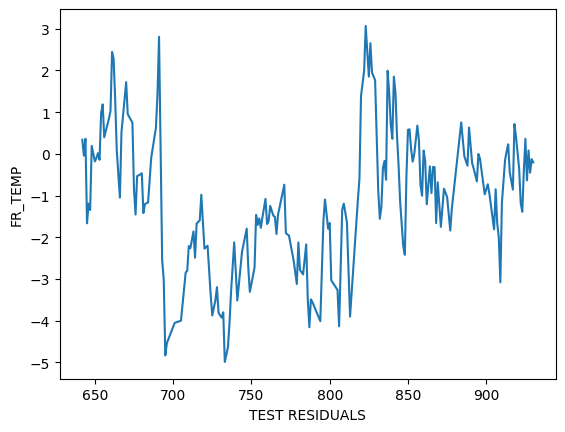

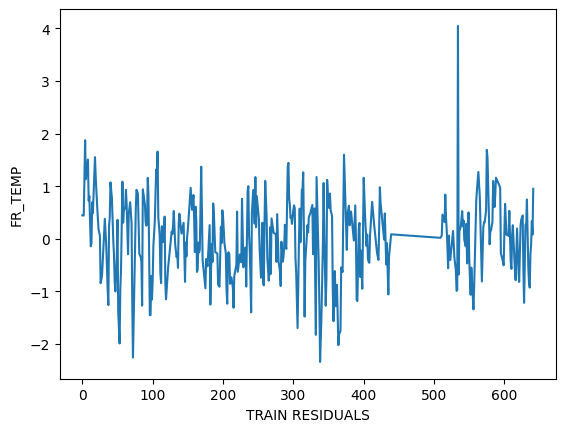

In [21]:
ridge = linear_model.Ridge(alpha=0.1)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=6.8)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

### Output

In [22]:
weather_forecast = de[de['DE_WIND'].isna()][weather_vars]

#### DE_WIND

In [23]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=3)
xgb_model.fit(weather_train, y['DE_WIND'])
weather_forecast['DE_WIND'] = xgb_model.predict(weather_test)

#### FR_WIND

In [24]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=0.5)
xgb_model.fit(weather_train, y['FR_WIND'])
weather_forecast['FR_WIND'] = xgb_model.predict(weather_test)

In [25]:
weather_forecast

,DE_RAIN,DE_WIND,DE_TEMP,FR_RAIN,FR_WIND,FR_TEMP
ID,,,,,,
442,NaN,-0.546348,NaN,NaN,-0.838179,NaN
443,NaN,-0.546348,NaN,NaN,-0.946704,NaN
444,NaN,-0.620654,NaN,NaN,-0.946704,NaN
446,NaN,-0.231036,NaN,NaN,-0.705956,NaN
449,NaN,-0.546348,NaN,NaN,-0.289009,NaN
451,NaN,-0.428644,NaN,NaN,-0.700205,NaN
453,NaN,-0.027016,NaN,NaN,0.324443,NaN
455,NaN,-0.344020,NaN,NaN,-0.602188,NaN
456,NaN,-0.620654,NaN,NaN,-0.645237,NaN
